In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
from functools import partial

import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from fastai.core import T
from fastai.rnn_reg import EmbeddingDropout
from torch.optim import Adam
import torch.nn as nn
import torch
import torch.nn.functional as F
import sentencepiece as spm

from cnlp.fastai_extended import LanguageModelLoader, LanguageModelData, ShuffledLanguageModelLoader

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [3]:
tokens = joblib.load("../data/tokens_unigram.pkl")

In [4]:
# Filter out empty texts
tokens = [x for x in tokens if x.shape[0] > 0]

In [5]:
# Set shuffle = False to keep sentences from the same paragraph together
trn_tokens, val_tokens = train_test_split(tokens, test_size=0.2, shuffle=False)
val_tokens, tst_tokens = train_test_split(val_tokens, test_size=0.5, shuffle=False)

In [6]:
def get_voc_stats(tokens):
    total_tokens = np.sum([x.shape[0] for x in tokens])
    unks = np.sum([np.sum(x == 0) for x in tokens])
    print("Total tokens: %d\nUnknown Percentage: %.2f %%" % (total_tokens, unks * 100 / total_tokens))
get_voc_stats(tokens)

Total tokens: 82818072
Unknown Percentage: 0.89 %


In [7]:
bptt = 100
batch_size = 64
n_tok = int(np.max([np.max(x) for x in tokens]) + 1)
trn_loader = ShuffledLanguageModelLoader(
    np.concatenate(trn_tokens), batch_size, bptt, target_length=90, batch_first=True)
val_loader = ShuffledLanguageModelLoader(
    np.concatenate(val_tokens), batch_size,   bptt, target_length=90, batch_first=True)
tst_loader = ShuffledLanguageModelLoader(
    np.concatenate(tst_tokens), batch_size, bptt, target_length=90, batch_first=True)

In [8]:
sp = spm.SentencePieceProcessor()
sp.Load("../data/unigram_model.model")

True

In [10]:
np.sum([np.sum(x == 2) for x in tokens]) # </s>

0

In [11]:
sp.DecodeIds(trn_tokens[0].tolist())

'每当 有 涉及 数量 、 结构 、 空间 及 变化 等 方面 的 困难 问题 时 , 通常 就 需要 用 到 数学 工具 去 解决 问题 , 而 这 往往 也 拓展 了 数学 的 研究 范畴 。'

In [12]:
path = Path("../data/cache/lm_unigram_transformer/")
path.mkdir(parents=True, exist_ok=True)
model_data = LanguageModelData(
    path, pad_idx=2, n_tok=n_tok, trn_dl=trn_loader, val_dl=val_loader, test_dl=tst_loader
)

In [13]:
n_tok

7500

### Transformer Model

In [13]:
drops = np.array([0.1, 0.1, 0.05, 0, 0.1])
learner = model_data.get_model(
    partial(Adam, betas=(0.8, 0.999)),
    emb_sz=300, n_hid=500, n_layers=3,
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2],
    dropoute=drops[3], dropouth=drops[4], qrnn=False
)

In [14]:
# Courtesy of https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model
pytorch_total_params = sum(p.numel() for p in learner.model.parameters())
pytorch_trainable_params = sum(p.numel() for p in learner.model.parameters() if p.requires_grad)
pytorch_total_params, pytorch_trainable_params

(6820400, 6820400)

In [14]:
learner = model_data.get_transformer_model(
    partial(Adam, betas=(0.8, 0.99)),
    max_seq_len=trn_loader.max_possible_seq_len,
    emb_sz=480,
    n_head=12,
    n_layer=6,
    embd_pdrop=0.1,
    attn_pdrop=0.1,
    resid_pdrop=0.1
)

In [15]:
pytorch_total_params = sum(p.numel() for p in learner.model.parameters())
pytorch_trainable_params = sum(p.numel() for p in learner.model.parameters() if p.requires_grad)
pytorch_total_params, pytorch_trainable_params

(23874240, 23874240)

epoch      trn_loss   val_loss                                    
    0      7.324165   7.402546  

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 17.5 ms


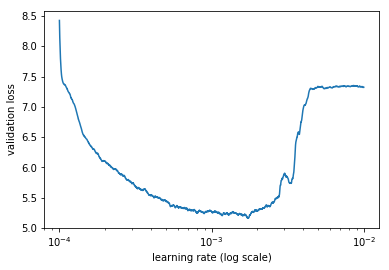

In [17]:
learner.clip = 10.
learner.lr_find(start_lr=1e-4, end_lr=1e-2, linear=False)
%time learner.sched.plot()

In [16]:
lrs = 1e-3
learner.clip = 20.
%time learner.fit(lrs, 1, wds=0, use_clr=(50, 4), cycle_len=5, use_wd_sched=False)

epoch      trn_loss   val_loss                                    
    0      4.794342   4.703889  
    1      4.436281   4.371821                                    
    2      4.25518    4.184691                                    
    3      4.122174   4.073596                                    
    4      4.036487   3.993604                                    

CPU times: user 3h 7min 40s, sys: 2h 18min 41s, total: 5h 26min 22s
Wall time: 5h 26min 7s


[3.993603613417027]

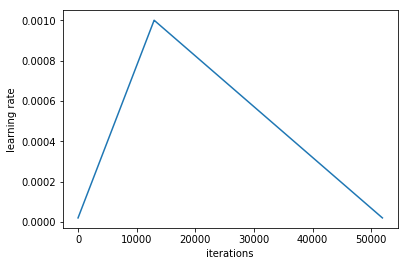

In [17]:
learner.sched.plot_lr()

In [18]:
learner.save("lm_transformer")
learner.save_encoder("lm_transformer_enc")

In [19]:
tmp_iter = iter(trn_loader)

In [20]:
next(tmp_iter)[0].shape

torch.Size([64, 100])

In [21]:
learner.load("lm_transformer")

## Test the model

In [22]:
learner.model.eval()

SequentialRNN(
  (0): TransformerEncoder(
    (embed): Embedding(7600, 480, padding_idx=2)
    (drop): LockedDropout()
    (blocks): ModuleList(
      (0): Block(
        (attn): Attention(
          (c_attn): Linear(in_features=480, out_features=1440, bias=True)
          (c_proj): Linear(in_features=480, out_features=480, bias=True)
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): LockedDropout()
        )
        (ln_1): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=480, out_features=1920, bias=True)
          (c_proj): Linear(in_features=1920, out_features=480, bias=True)
          (dropout): Dropout(p=0.1)
        )
        (ln_2): LayerNorm()
      )
      (1): Block(
        (attn): Attention(
          (c_attn): Linear(in_features=480, out_features=1440, bias=True)
          (c_proj): Linear(in_features=480, out_features=480, bias=True)
          (attn_dropout): Dropout(p=0.1)
          (resid_dropout): LockedDropout()
        )
       

### Next Character Inference

In [23]:
tokens = sp.EncodeAsIds("德国 是 世界 大国 之 一 ， 其 国内 生产 总 值 以 国际 汇率 计")
tokens

[513,
 11,
 314,
 29,
 95,
 45,
 14,
 4,
 51,
 1690,
 712,
 195,
 3,
 1156,
 34,
 354,
 2923,
 450,
 3523]

In [24]:
iterator = iter(tst_loader)
x, y = next(iterator)

In [25]:
x.shape, y.shape

(torch.Size([64, 100]), torch.Size([5760]))

In [26]:
logits = learner.model(x.to("cuda"))
logits.shape

torch.Size([5760, 7500])

In [31]:
def eval_tensors(x, y):
    logits = learner.model(x.to("cuda"))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
    print(x.shape, len(preds[0]))
    return pd.DataFrame({
        "orig": [sp.IdToPiece(int(i)) for i in x[0, 10:].numpy()] + [""], 
        "pred_1": [""] + preds[0], "pred_2": [""] + preds[1], "pred_3": [""] + preds[2],
        "actual": [""] + [sp.IdToPiece(int(i)) for i in y.numpy()]
    })
tmp = eval_tensors(x[:1, :], y[:90])
tmp[:20]

torch.Size([1, 100]) 90


,actual,orig,pred_1,pred_2,pred_3
0,,"▁,",,,
1,▁它,▁它,▁但,▁并,▁而
2,们,们,们,▁的,▁也
3,▁要,▁要,▁在,▁认为,▁不
4,么,么,▁,▁在,么
5,▁只,▁只,▁是,▁可以,▁不
6,▁为,▁为,▁是,▁有,▁会
7,▁异,▁异,▁,▁该,▁自己
8,性,性,议,端,性
9,▁,▁,恋,▁,▁婚姻


In [32]:
tmp.iloc[-20:]

,actual,orig,pred_1,pred_2,pred_3
71,▁法院,▁法院,▁法院,▁人民,法
72,▁,▁,▁的,▁都,▁在
73,驳,驳,裁,驳,控
74,回,回,回,斥,议
75,▁了,▁了,▁了,▁这,"▁,"
76,▁该,▁该,▁,▁这,▁该
77,州,州,案,州,▁修正
78,▁政府,▁政府,▁的,▁宪法,▁最高
79,▁,▁,▁的,▁对,"▁,"
80,暂,暂,“,诉,裁


In [34]:
tmp = eval_tensors(x[1:2, :], y[90:180])
tmp[-20:]

torch.Size([1, 100]) 90


,actual,orig,pred_1,pred_2,pred_3
71,▁等,▁等,▁、,▁等,▁三
72,▁人,▁人,▁人,▁将领,▁
73,▁击退,▁击退,"▁,",▁,▁在
74,之,之,"▁,",▁。,▁了
75,"▁,","▁,",▁。,"▁,",战
76,▁罗,▁罗,▁,▁并,▁但
77,世,世,世,▁世,纪
78,▁被,▁被,▁和,▁与,▁、
79,▁封,▁封,俘,▁,▁杀
80,▁为,▁为,▁为,为,赏


In [68]:
def eval_text(texts):
    tokens = sp.EncodeAsIds(texts)[:100]
    logits = learner.model(T(tokens).unsqueeze(0))
    sorted_idx = np.argsort(logits.data.cpu().numpy(), 1)
    preds = []
    for i in range(1, 4):
          preds.append([sp.IdToPiece(x) for x in sorted_idx[:, -i].tolist()])
    # preds = list(map(lambda x: itos[x], np.argmax(logits.data.cpu().numpy(), 1)))
    print(len(preds[0]))
    return pd.DataFrame({"orig": sp.EncodeAsPieces(texts)[-90:] + [""], 
                  "pred_1": [""] + preds[0][-90:], "pred_2": [""] + preds[1][-90:], "pred_3": [""] + preds[2][-90:]})

In [63]:
sp.DecodeIds(x[0, :].numpy().tolist())

'的 20 个 县 则 选择 拒绝 执行 该 判决 , 它们 要么 只 为 异性 伴侣 发放 结婚 证书 , 要么 完全 停止 向 任何 伴侣 发放 结婚 证书 。 在 两 起 案件 中 , 一个 联邦 地区 法院 判定 阿拉巴马州 对 同性 婚姻 的 禁令 违宪 。 美国 联邦 第十一 巡回 上诉 法院 和 最高 法院 驳回 了 该州 政府 暂缓 执行 的 请求 。 2015年 3月'

In [64]:
tmp = eval_text(sp.DecodeIds(x[6, :].numpy().tolist()))
tmp

90 90


,orig,pred_1,pred_2,pred_3
0,▁海,,,
1,滩,滩,关,盗
2,▁一,▁上,▁的,▁是
3,▁艘,▁号,▁,共
4,▁载,"▁,",▁船,▁
5,有,有,▁着,运
6,▁六,▁,▁一,▁1
7,▁名,▁艘,百,十
8,▁船员,▁船员,▁乘客,▁
9,▁和,"▁,",▁的,▁和


In [69]:
eval_text("特朗普 政府 以为 加征 关税 会 令 中国 屈服 ， 这种 策略 肯定 会 适得其反 ， 如果 就业 和 财富")

33


,orig,pred_1,pred_2,pred_3
0,▁特,,,
1,朗,▁特,特,▁
2,普,▁,斯,▁·
3,▁政府,斯,利,▁
4,▁以为,▁,▁及,▁的
5,▁加,▁会,▁是,▁
6,征,利,菲,特
7,▁关,▁的,▁,会
8,税,普,特,克
9,▁会,▁关,▁的,▁


In [70]:
eval_text("对 中国 与 南洋 发动 全面 的 战争 。 1990 年代 ， 中")

14


,orig,pred_1,pred_2,pred_3
0,▁对,,,
1,▁中国,<unk>,”,▁
2,▁与,▁,▁中国,"▁,"
3,▁南,▁,▁中国,▁朝鲜
4,洋,▁,▁中国,▁朝鲜
5,▁发动,▁,▁的,"▁,"
6,▁全面,▁,▁战争,▁进攻
7,▁的,▁,▁战争,▁侵略
8,▁战争,▁,▁对,谍
9,▁。,"▁,",▁,▁。
